<a href="https://colab.research.google.com/github/AishwaryaKalloli/MIT6x978-homework/blob/main/pset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]


# c. Training Function

In [4]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# d. Evaluation Function

In [5]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [6]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"

        # encoder
        modules = []
        last_dim = input_dim
        for dim in hidden_dims:
            modules.append(torch.nn.Linear(last_dim, dim))
            modules.append(torch.nn.ReLU())
            last_dim = dim
        self.encoder = torch.nn.Sequential(*modules)

        # decoder
        modules = []
        last_dim = hidden_dims[-1]
        for dim in hidden_dims[len(hidden_dims) - 2::-1]:
            modules.append(torch.nn.Linear(last_dim, dim))
            modules.append(torch.nn.ReLU())
            last_dim = dim
        modules.append(torch.nn.Linear(last_dim, input_dim))
        self.decoder = torch.nn.Sequential(*modules)


    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [22]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    # mean squared loss or L2 loss
    return mse(reconstructed, x)


In [23]:
def get_model(input_dim, hidden_dims, lr=1e-3, weight_decay=1e-8):
    ae = AE(input_dim, hidden_dims).to(device)
    print(ae)
    # using Adam optimiser
    return torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


In [24]:
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

input_dim:  784


In [25]:
# Experimental hidden layers
experimental_hidden_dims = [[128, 32, 16, 2], [400, 200, 100, 50, 20, 2]]
# Experimental hyperparameters
experimental_hyperparameters = [(1e-2, 1e-8), (1e-3, 1e-8), (1e-4, 1e-8), (1e-5, 1e-8)]

models = [get_model]

In [18]:
def plot_multiple_training_curves(training_results, batch_size, dataset_size,
                                 save_plot=True, plot_title="Hyperparameter Comparison"):
    """
    Plot multiple training curves for different hyperparameter configurations

    Args:
        training_results: List of tuples (losses, hyperparams_dict, model_name, epochs)
                         where losses is the training loss list,
                         hyperparams_dict is a dict of hyperparameters,
                         model_name is a string identifier,
                         and epochs is the number of epochs for this training run
        batch_size: Batch size used in training
        dataset_size: Total size of the dataset
        save_plot: Whether to save the plot to file
        plot_title: Title for the overall plot
    """
    # Calculate accurate number of batches per epoch
    num_batches_per_epoch = int(np.ceil(dataset_size / batch_size))

    # Create the plot
    plt.figure(figsize=(15, 10))

    # Plot 1: All training curves
    plt.subplot(2, 2, 1)
    colors = plt.cm.tab10(np.linspace(0, 1, len(training_results)))

    max_epochs = 0
    for idx, (losses, hyperparams, model_name, epochs) in enumerate(training_results):
        # Calculate epoch losses
        epoch_losses = []
        for i in range(epochs):
            start_idx = i * num_batches_per_epoch
            end_idx = start_idx + num_batches_per_epoch
            epoch_avg = np.mean(losses[start_idx:end_idx])
            epoch_losses.append(epoch_avg)

        plt.plot(range(1, epochs + 1), epoch_losses, color=colors[idx], linewidth=2, marker='o',
                markersize=4, label=model_name, alpha=0.8)
        max_epochs = max(max_epochs, epochs)

    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title(f'{plot_title} - Training Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 2: Final losses comparison
    plt.subplot(2, 2, 2)
    final_losses = []
    model_names = []

    for losses, hyperparams, model_name, epochs in training_results:
        epoch_losses = []
        for i in range(epochs):
            start_idx = i * num_batches_per_epoch
            end_idx = start_idx + num_batches_per_epoch
            epoch_avg = np.mean(losses[start_idx:end_idx])
            epoch_losses.append(epoch_avg)

        final_losses.append(epoch_losses[-1])
        model_names.append(model_name)

    bars = plt.bar(range(len(final_losses)), final_losses, color=colors[:len(final_losses)])
    plt.xlabel('Model Configuration')
    plt.ylabel('Final Loss')
    plt.title('Final Loss Comparison')
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')

    # Add value labels on bars
    for bar, loss in zip(bars, final_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{loss:.4f}', ha='center', va='bottom', fontsize=8)

    plt.grid(True, alpha=0.3)

    # Plot 3: Best losses comparison
    plt.subplot(2, 2, 3)
    best_losses = []

    for losses, hyperparams, model_name, epochs in training_results:
        epoch_losses = []
        for i in range(epochs):
            start_idx = i * num_batches_per_epoch
            end_idx = start_idx + num_batches_per_epoch
            epoch_avg = np.mean(losses[start_idx:end_idx])
            epoch_losses.append(epoch_avg)

        best_losses.append(min(epoch_losses))

    bars = plt.bar(range(len(best_losses)), best_losses, color=colors[:len(best_losses)])
    plt.xlabel('Model Configuration')
    plt.ylabel('Best Loss')
    plt.title('Best Loss Comparison')
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')

    # Add value labels on bars
    for bar, loss in zip(bars, best_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{loss:.4f}', ha='center', va='bottom', fontsize=8)

    plt.grid(True, alpha=0.3)

    # Plot 4: Hyperparameter summary table
    plt.subplot(2, 2, 4)
    plt.axis('off')

    # Create summary table
    table_data = []
    for losses, hyperparams, model_name, epochs in training_results:
        epoch_losses = []
        for i in range(epochs):
            start_idx = i * num_batches_per_epoch
            end_idx = start_idx + num_batches_per_epoch
            epoch_avg = np.mean(losses[start_idx:end_idx])
            epoch_losses.append(epoch_avg)

        row = [model_name, f"{epochs}", f"{epoch_losses[-1]:.4f}", f"{min(epoch_losses):.4f}",
               f"{np.argmin(epoch_losses) + 1}"]
        table_data.append(row)

    table = plt.table(cellText=table_data,
                     colLabels=['Model', 'Epochs', 'Final Loss', 'Best Loss', 'Best Epoch'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    plt.title('Training Summary')

    plt.tight_layout()
    plt.show()

    # Save plot if requested
    if save_plot:
        plt.savefig(f'{plot_title.lower().replace(" ", "_")}_hyperparameter_comparison.png',
                   dpi=300, bbox_inches='tight')
        print(f"Hyperparameter comparison plot saved as {plot_title.lower().replace(' ', '_')}_hyperparameter_comparison.png")

    return training_results

# Example usage:
# After training multiple models with different hyperparameters:
# training_results = [
#     (log_ae_1, {"lr": 1e-3, "hidden_dims": [128, 32, 16, 2]}, "AE (lr=1e-3)", 20),
#     (log_ae_2, {"lr": 1e-4, "hidden_dims": [128, 32, 16, 2]}, "AE (lr=1e-4)", 30),
#     (log_ae_3, {"lr": 1e-3, "hidden_dims": [256, 64, 32, 2]}, "AE (larger)", 25),
# ]
# plot_multiple_training_curves(training_results, batch_size=256,
#                              dataset_size=len(MNIST_dataset),
#                              plot_title="AutoEncoder Hyperparameter Comparison")

# Example usage:
# After training your AE model, you can use:
# epoch_losses_ae = plot_training_losses(log_ae, epochs=20, model_name="AutoEncoder (AE)")
# print(f"Final epoch loss: {epoch_losses_ae[-1]:.4f}")
# print(f"Best epoch loss: {min(epoch_losses_ae):.4f} at epoch {np.argmin(epoch_losses_ae) + 1}")

In [ ]:
import os
import torch

def save_checkpoint(model, optimizer, epoch, loss, model_name="model"):
    """
    Save model checkpoint

    Args:
        model: PyTorch model
        optimizer: PyTorch optimizer
        epoch: Current epoch
        loss: Current loss value
        model_name: Name for the checkpoint file
    """
    # Create checkpoints directory if it doesn't exist
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(checkpoint, f'checkpoints/{model_name}_epoch_{epoch}.pth')
    print(f"Checkpoint saved: {model_name}_epoch_{epoch}.pth")

def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model checkpoint

    Args:
        model: PyTorch model
        optimizer: PyTorch optimizer
        checkpoint_path: Path to checkpoint file

    Returns:
        Dictionary with checkpoint information
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint

## c. Training


In [10]:
##################
### Problem 1 (b): Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)
##################


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0244



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0203



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0186



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0175



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0165



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0162



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0160



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0157



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0155



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0153



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0151



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0150



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0150



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0149

_________________________________________________________________________________________________________________________________________________________
[0.12190834432840347, 0.11877359449863434, 0.11262515932321548, 0.11145628243684769, 0.10564147680997849, 0.10494232177734375, 0.10292734205722809, 0.10016438364982605, 0.09884520620107651, 0.1021789088845253, 0.0979723110795021, 0.09203767776489258, 0.09210730344057083, 0.08817197382450104, 0.08782567828893661, 0.08360675722360611, 0.08223715424537659, 0.08233229070901871, 0.07771966606378555, 0.0775773674249649, 0.07610932737588882, 0.07228545844554901, 0.06986673921346664, 0.07174269109964371, 0.07082047313451767, 0.07100093364715576, 0.07069067656993866, 0.06871262192726135, 0.06799101084470749, 0.0701460912823677, 0.06734379380941391, 0.065027616918087, 0.06588728725910187, 0.06663963198661804, 0.06829274445772171, 0.06711810827255249, 0.06665604561567307, 0.06558975577354431, 0.066279381

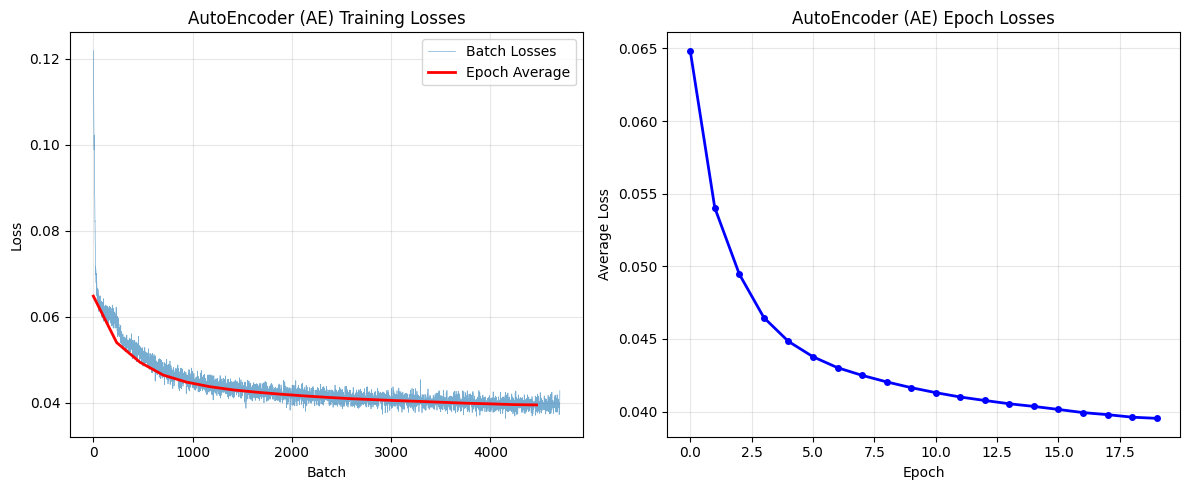

Loss plot saved as autoencoder_(ae)_training_losses.png
Final epoch loss: 0.0395
Best epoch loss: 0.0395 at epoch 20 of total 20 epochs


<Figure size 640x480 with 0 Axes>

In [16]:
# Example usage:
# After training your AE model, you can use:

epoch_losses_ae = plot_training_losses(log_ae, epochs=20, model_name="AutoEncoder (AE)")
print(f"Final epoch loss: {epoch_losses_ae[-1]:.4f}")
print(f"Best epoch loss: {min(epoch_losses_ae):.4f} at epoch {np.argmin(epoch_losses_ae) + 1} of total {len(epoch_losses_ae)} epochs")

## d. Evaluation


In [ ]:
##################
### Problem 1 (b): Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2

      self.encoder = torch.nn.Sequential()
      self.decoder = torch.nn.Sequential()
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      pass

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = vae_test(test_tensor)


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [ ]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    pass

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [ ]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


In [ ]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))

with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [ ]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-3

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1e-3), optimizer_vae_sgvb, epochs)
##################


## e. Evaluation

In [ ]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [ ]:
##################
### Problem 3(c): Train VAE with analytical KL
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-3), optimizer_vae_kl_wo_e, epochs)
##################


## g. Evaluation

In [ ]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################


# **3. Torus**

## a. Data Generation

In [ ]:
def generate_torus_point_cloud(R, r, num_points=1000, seed=1234):
    """
    Parameters:
    - R: Major radius of the torus (distance from the center of the tube to the center of the torus).
    - r: Minor radius of the torus (radius of the tube).
    - num_points: Number of points to sample in the point cloud.

    Returns:
    - x, y, z: Arrays containing the x, y, and z coordinates of the sampled points.
    """
    np.random.seed(seed)
    u = np.random.uniform(0, 2 * np.pi, num_points)
    np.random.seed(seed+1)
    v = np.random.uniform(0, 2 * np.pi, num_points)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    points = np.vstack((x, y, z)).T

    return points

def plot_torus_point_cloud(x, y, z, ax, color='b', name='Training Data'):
    """
    Plots the 3D point cloud of a torus.
    """
    ax.scatter(x, y, z, c=color, marker='o', s=5)

    # Set equal scaling for all axes
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(name)
    return ax

class TorusPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, R, r, num_points=1000):
        """
        Args:
            R (float): Major radius of the torus.
            r (float): Minor radius of the torus.
            num_points (int): Number of points to generate.
        """
        points = generate_torus_point_cloud(R, r, num_points)
        self.points = torch.tensor(points, dtype=torch.float32)

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], 0 # dummy label

R = 1.0
r = 0.5
num_points = 3000

torus_pc_dataset = TorusPointCloudDataset(R, r, num_points)
torus_pc_dataloader = torch.utils.data.DataLoader(torus_pc_dataset, batch_size=3000, shuffle=True)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(torus_pc_dataset.points[:, 0], torus_pc_dataset.points[:, 1], torus_pc_dataset.points[:, 2], ax)
plt.show()


## b. Network Architecture

In [ ]:
class PositionalEncoding3D(torch.nn.Module):
    def __init__(self, num_frequencies=10):
        """
        Initializes the positional encoding for 3D coordinates.

        Args:
            num_frequencies (int): The number of different frequencies to use for encoding.
        """
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = 2 ** torch.arange(num_frequencies, dtype=torch.float32)

    def forward(self, points):
        """
        Applies positional encoding to the 3D points.

        Args:
            points (torch.Tensor): N x 3 tensor of 3D coordinates.

        Returns:
            torch.Tensor: N x (6*num_frequencies) tensor of encoded coordinates.
        """
        encoded_points = []
        for i in range(points.shape[1]):  # For each dimension (x, y, z)
            for freq in self.frequencies:
                encoded_points.append(torch.sin(freq * points[:, i:i+1]))
                encoded_points.append(torch.cos(freq * points[:, i:i+1]))
        return torch.cat(encoded_points, dim=-1)

###############
### Problem 4(c): Create your own VAE
###############

class PointVAE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()

        self.pos_enc = PositionalEncoding3D()
        #############
        ### Problem 4(c): Create your own VAE
        self.vae = VAE(input_dim=self.pos_enc.num_frequencies * 6, hidden_dims=hidden_dims, decode_dim=3, use_sigmoid=False)
        #############

    def forward(self, x):
        emb = self.pos_enc(x)
        return self.vae(emb)


## c. Training

In [ ]:
#############
### Problem 4(a): Train VAE on torus data
epochs = 1000

hidden_dims = [32, 16, 8] # -> 2/3 dim

point_vae = PointVAE(hidden_dims).to(device)
print(point_vae)

optimizer_point_vae = torch.optim.Adam(point_vae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_point_vae = train(torus_pc_dataloader, point_vae, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=0.0), optimizer_point_vae, epochs)
#############


## d. Evaluation on Reconstruction

In [ ]:
#############
### Problem 4(a): Evaluation on reconstruction
with torch.no_grad():
  output = point_vae(torus_pc_dataset.points.to(device))
  decoded_pc = output['imgs'].cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
#############


## e. Evaluation on Interpolation

In [ ]:
#############
### Problem 4(v): Evaluation on linear interpolation
z0 = point_vae(torch.tensor([[0.0, 1.0, 0.]]).to(device))['z']
z1 = point_vae(torch.tensor([[0.0, -1.0, 0.]]).to(device))['z']

print(hidden_dims[-1])
num_steps = 100

weights = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
latent_vecs = weights * z0 + (1 - weights) * z1

with torch.no_grad():
    outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))

lin_traj = outputs.cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(lin_traj[:, 0], lin_traj[:, 1], lin_traj[:, 2], ax, color='r', name="Decoded Data")
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
plt.show()
#############
